In [1]:
import pandas as pd
import os
import numpy as np

import get_votos

import networkx as nx
import requests
import matplotlib.pyplot as plt

from matplotlib import rcParams
from cycler import cycler


In [2]:
#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [129]:
rootPath=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Abril19'
rootPath2=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Maio19'
rootPath3=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Março19'
rootPath4=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Junho19'
rootPath5=r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\Data3\56-LEG-PRIMEIRA-SESSAO-LEGISLATIVA-Julho19'
arquivo='Abril2019.csv'
arquivo2='Maio2019.csv'

filename=os.path.join(rootPath,arquivo)
filename2=os.path.join(rootPath2,arquivo2)

df_abril=get_votos.votos(rootPath)
df_maio=get_votos.votos(rootPath2)
df_marco=get_votos.votos(rootPath3)
df_junho=get_votos.votos(rootPath4)
df_julho=get_votos.votos(rootPath5)

In [105]:
def lado_partido(df_mes):
    
    GOVERNO=['PSL','PP','PSD','MDB','PR','PRB','DEM','PSDB','PTB','PMN','PSC','NOVO','PTC','PHS']
    BLOCO_A=['PDT','AVANTE','Avate','PATRI','PV','PROS','PPS','CIDADANIA','SOLIDARIEDADE','Solidariedade',\
             'PODE','PL','DC','PRP','PATRIOTA','Patriota','Podemos','S.Part.']
    OPOSICAO=['PT','PSOL','PSB','REDE','PCdoB','PPL']
    df_mes['Lado']=0
    for i in range(len(df_mes['Partido'])):
        if df_mes['Partido'].iloc[i] in GOVERNO:
            df_mes['Lado'].iloc[i]='GOVERNO'
        elif df_mes['Partido'].iloc[i] in OPOSICAO:
            df_mes['Lado'].iloc[i]='OPOSIÇÃO'
        elif df_mes['Partido'].iloc[i] in BLOCO_A:
            df_mes['Lado'].iloc[i]='BLOCO A'
        else:
            print(df_mes['Partido'].iloc[i])
            print(i)

In [130]:
lado_partido(df_julho)

C:\Users\Felipe\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


FILHO
78
EURICO
148
FREDERICO
219
COSTA
233
RODRIGUES
404


In [114]:
def rede_votos(df_mes):
    
    deputados = df_mes['Nome']
    pesos= {dep:{ped: 0 for ped in deputados if ped!=dep} for dep in deputados}
    
    tipos_votos=['Não', 'Sim','Abstenção','Obstrução']
    for pos,sessao in enumerate(df_mes.columns[4:]): # pega a coluna da sessao
        
        votos_sessao=df_mes[sessao] #pega todos os votos da sessao
            
        votou_sim=[]
        votou_nao=[]
        votou_abs=[]
        votou_obs=[]
        for ordem,v in enumerate(votos_sessao): #pega um voto da lista
            if v not in tipos_votos: #verifica se o deputado votou
                continue
            elif v=='Não':
                votou_nao.append(ordem)
            elif v=='Sim':
                votou_sim.append(ordem)
            elif v=='Abstenção':
                votou_abs.append(ordem)
            elif v=='Obstrução':
                votou_obs.append(ordem)
            
        for k1,dp1 in enumerate(votou_sim):
            for p2,dp2 in enumerate(votou_sim[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        for k1,dp1 in enumerate(votou_nao):
            for p2,dp2 in enumerate(votou_nao[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        for k1,dp1 in enumerate(votou_abs):
            for p2,dp2 in enumerate(votou_abs[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1
                
        for k1,dp1 in enumerate(votou_obs):
            for p2,dp2 in enumerate(votou_obs[k1+1:]):
               
                pesos[deputados.iloc[dp1]][deputados.iloc[dp2]]+=1                
                    
    g = nx.Graph()
    for par,nome in enumerate(deputados):
        g.add_node(nome)
        if df_mes['Lado'].iloc[par]=='GOVERNO':
            g.node[nome]['color'] ='b'
        elif df_mes['Lado'].iloc[par]=='OPOSIÇÃO':
            g.node[nome]['color'] ='r'
        elif df_mes['Lado'].iloc[par]=='BLOCO A':
            g.node[nome]['color'] ='y'
        else:
            g.node[nome]['color'] ='m'
    
    for dep1, vizinho in pesos.items():
        for dep2, peso in vizinho.items():
            if peso == 0:
                continue
            g.add_edge(dep1,dep2, weight= peso, difference = 1. / peso)
            
    return g

In [131]:
votes_net_jul=rede_votos(df_julho)

In [108]:
def mst_votes(votes_net_mes,nomes_dep=True):
    
    plt.figure(figsize=(15, 10))
    np.random.seed(5)
    mst = nx.minimum_spanning_tree(votes_net_mes, weight='difference')
    pos = nx.spring_layout(mst, iterations=900, k=.008, weight='difference')


    mst_edges = list(nx.minimum_spanning_edges(votes_net_mes, weight='difference'))

    nl = votes_net_mes.nodes()
    c = [votes_net_mes.node[n]['color'] for n in nl]


    nx.draw_networkx_edges(votes_net_mes, pos, edgelist=mst_edges, alpha=1)
    nx.draw_networkx_nodes(votes_net_mes, pos, nodelist = nl, node_color = c, node_size=60)

    for p in pos.values():
        p[1] += .02
    
    if nomes_dep==True:
        
        nx.draw_networkx_labels(votes_net_mes, pos, font_color='k', font_size=5)

    plt.title("MST of Vote Disagreement", fontsize=12)
    plt.xticks([])
    plt.yticks([])
    remove_border(left=False, bottom=False)



# Rede de votos de Abril

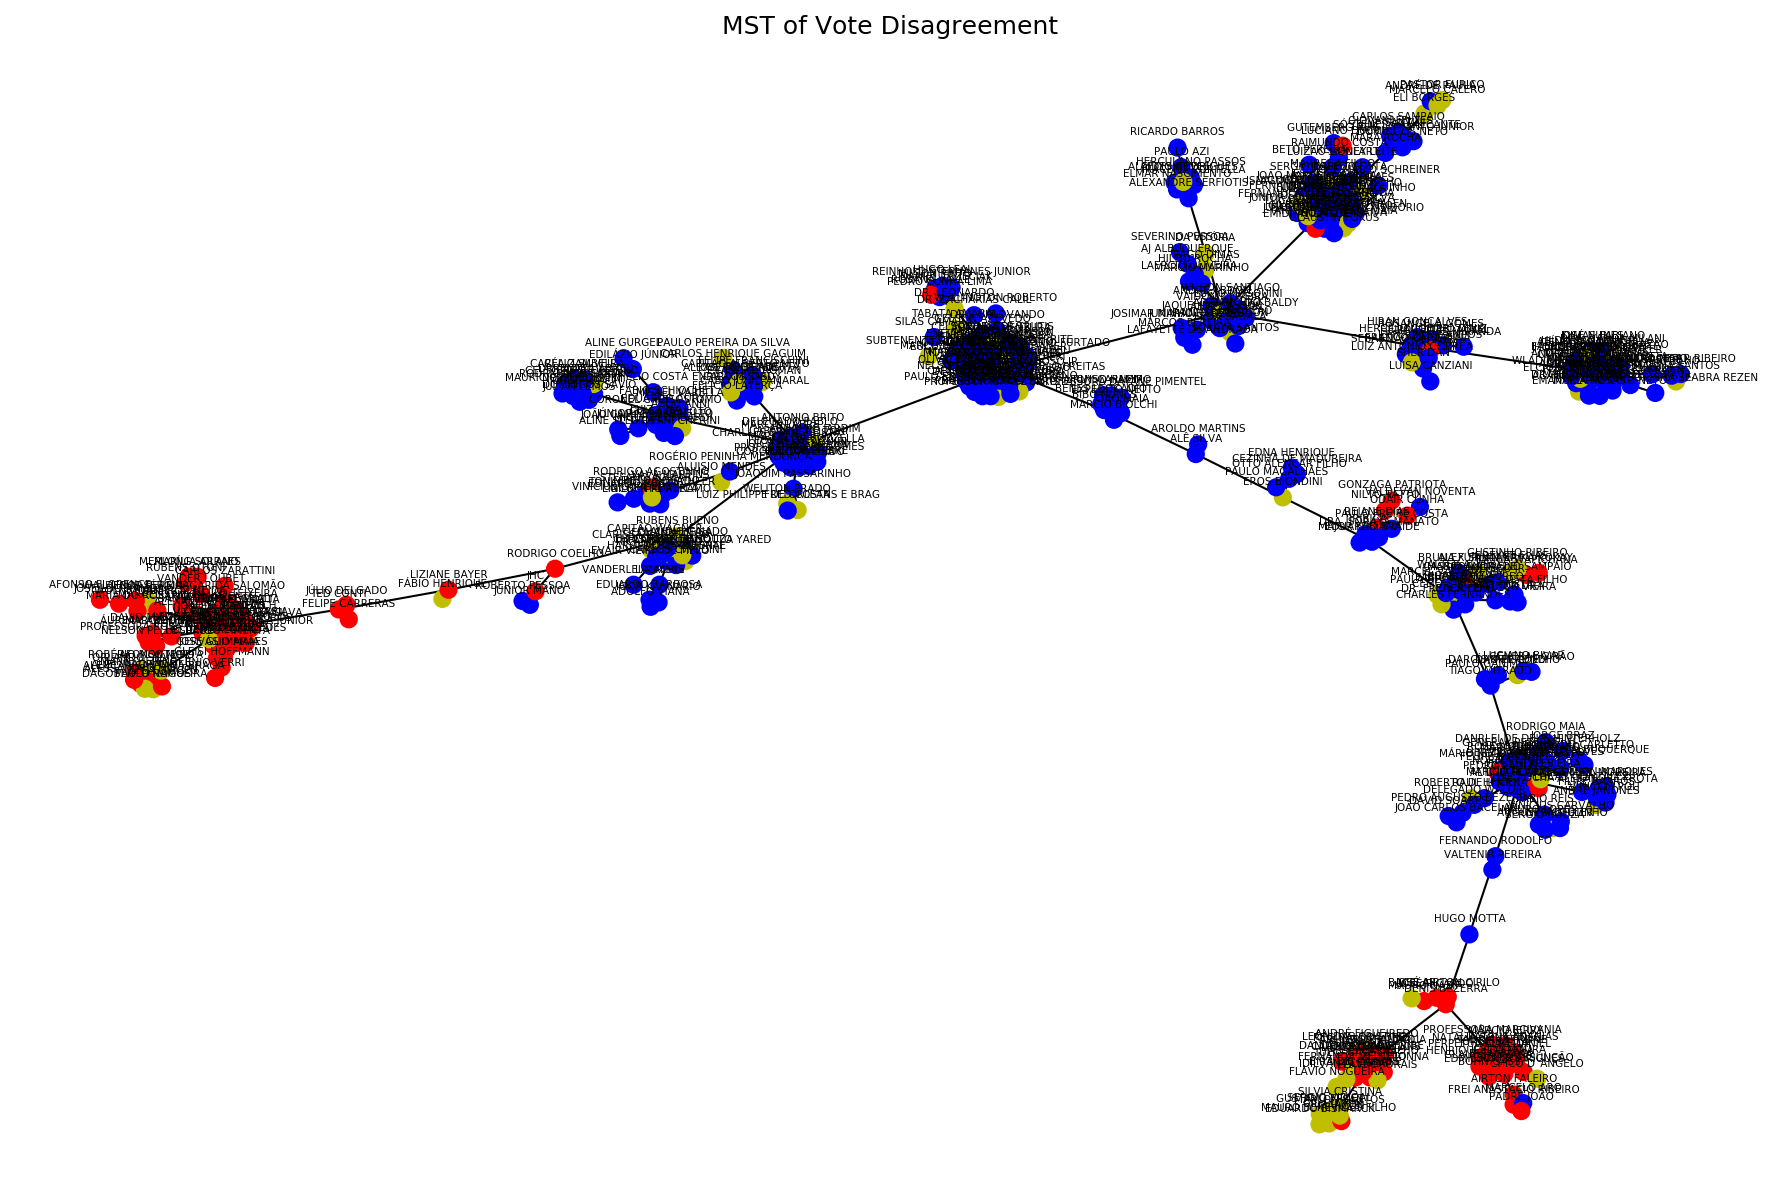

In [101]:
mst_votes(votes_net)

# Rede de votos de Março

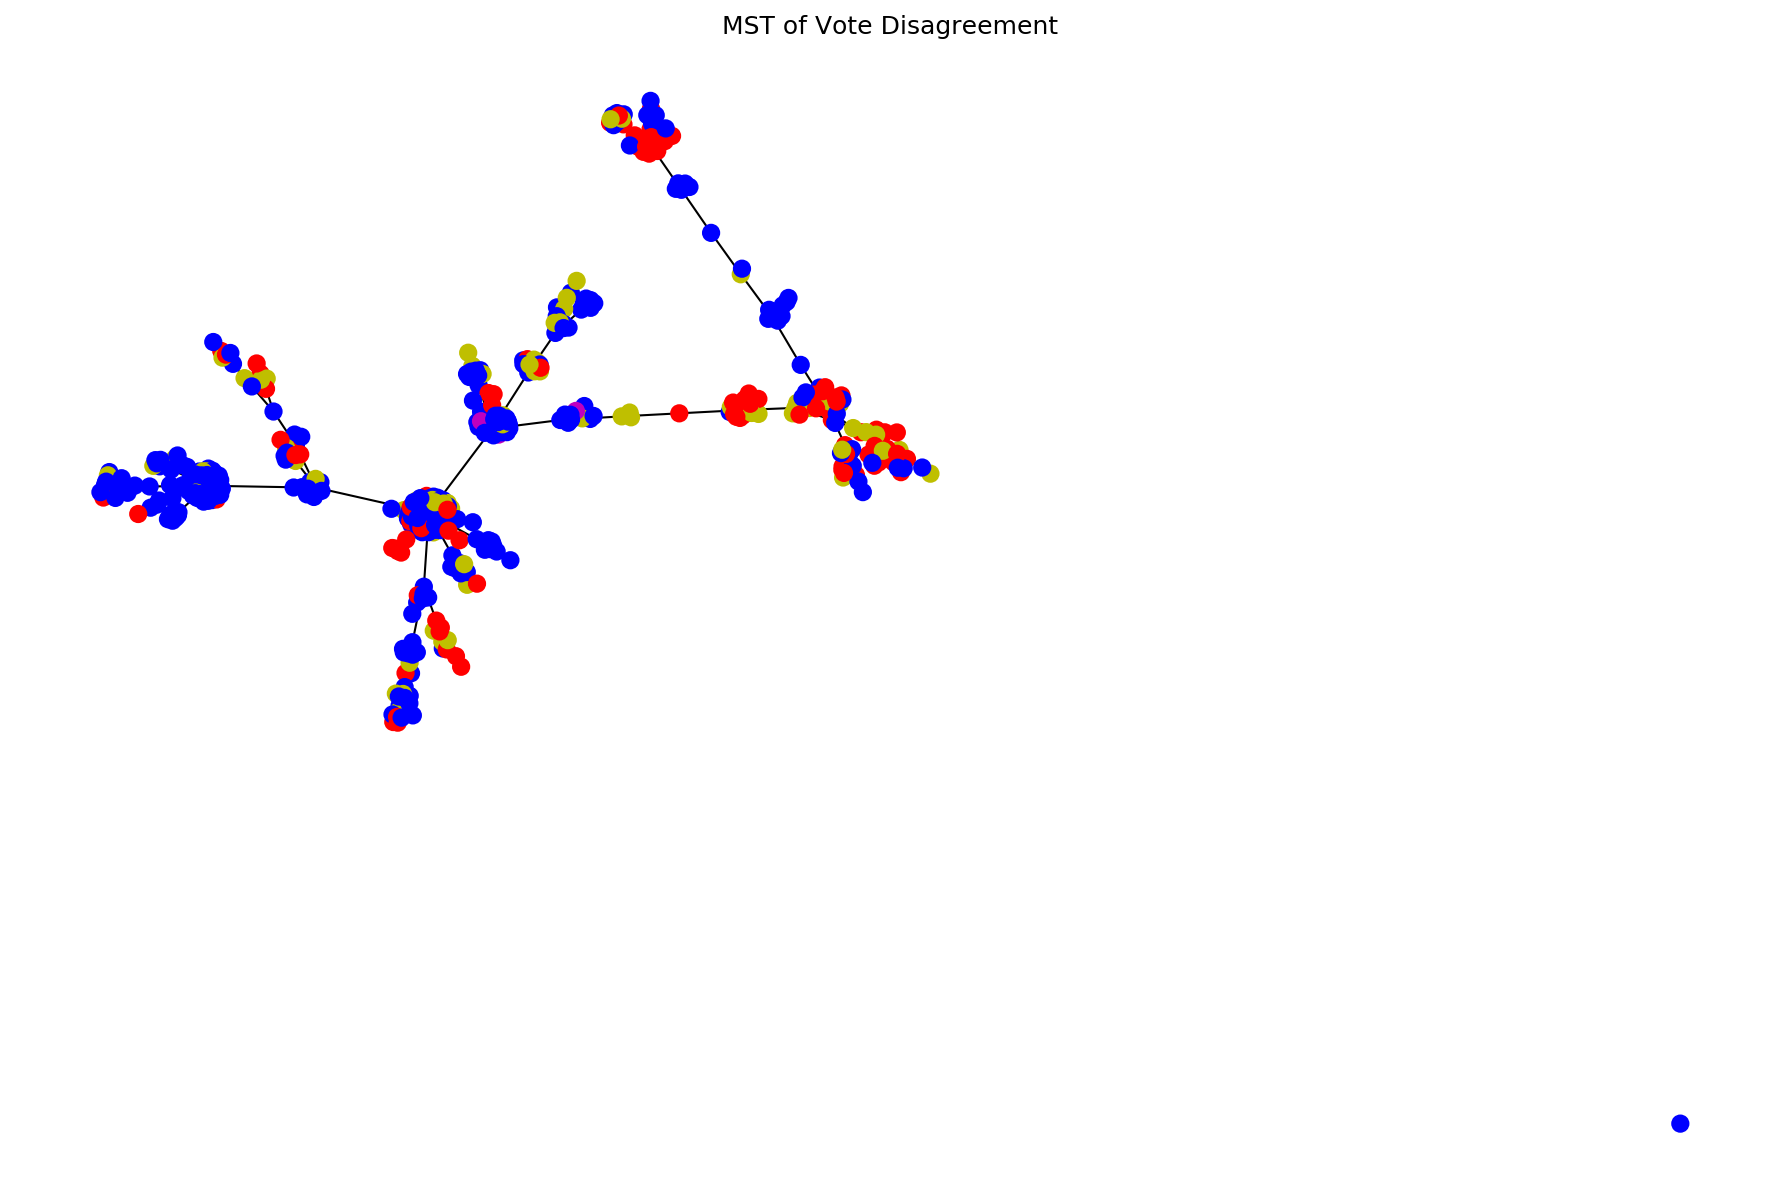

In [117]:
mst_votes(votes_net_mar,nomes_dep=False)

# Rede de votos de Junho

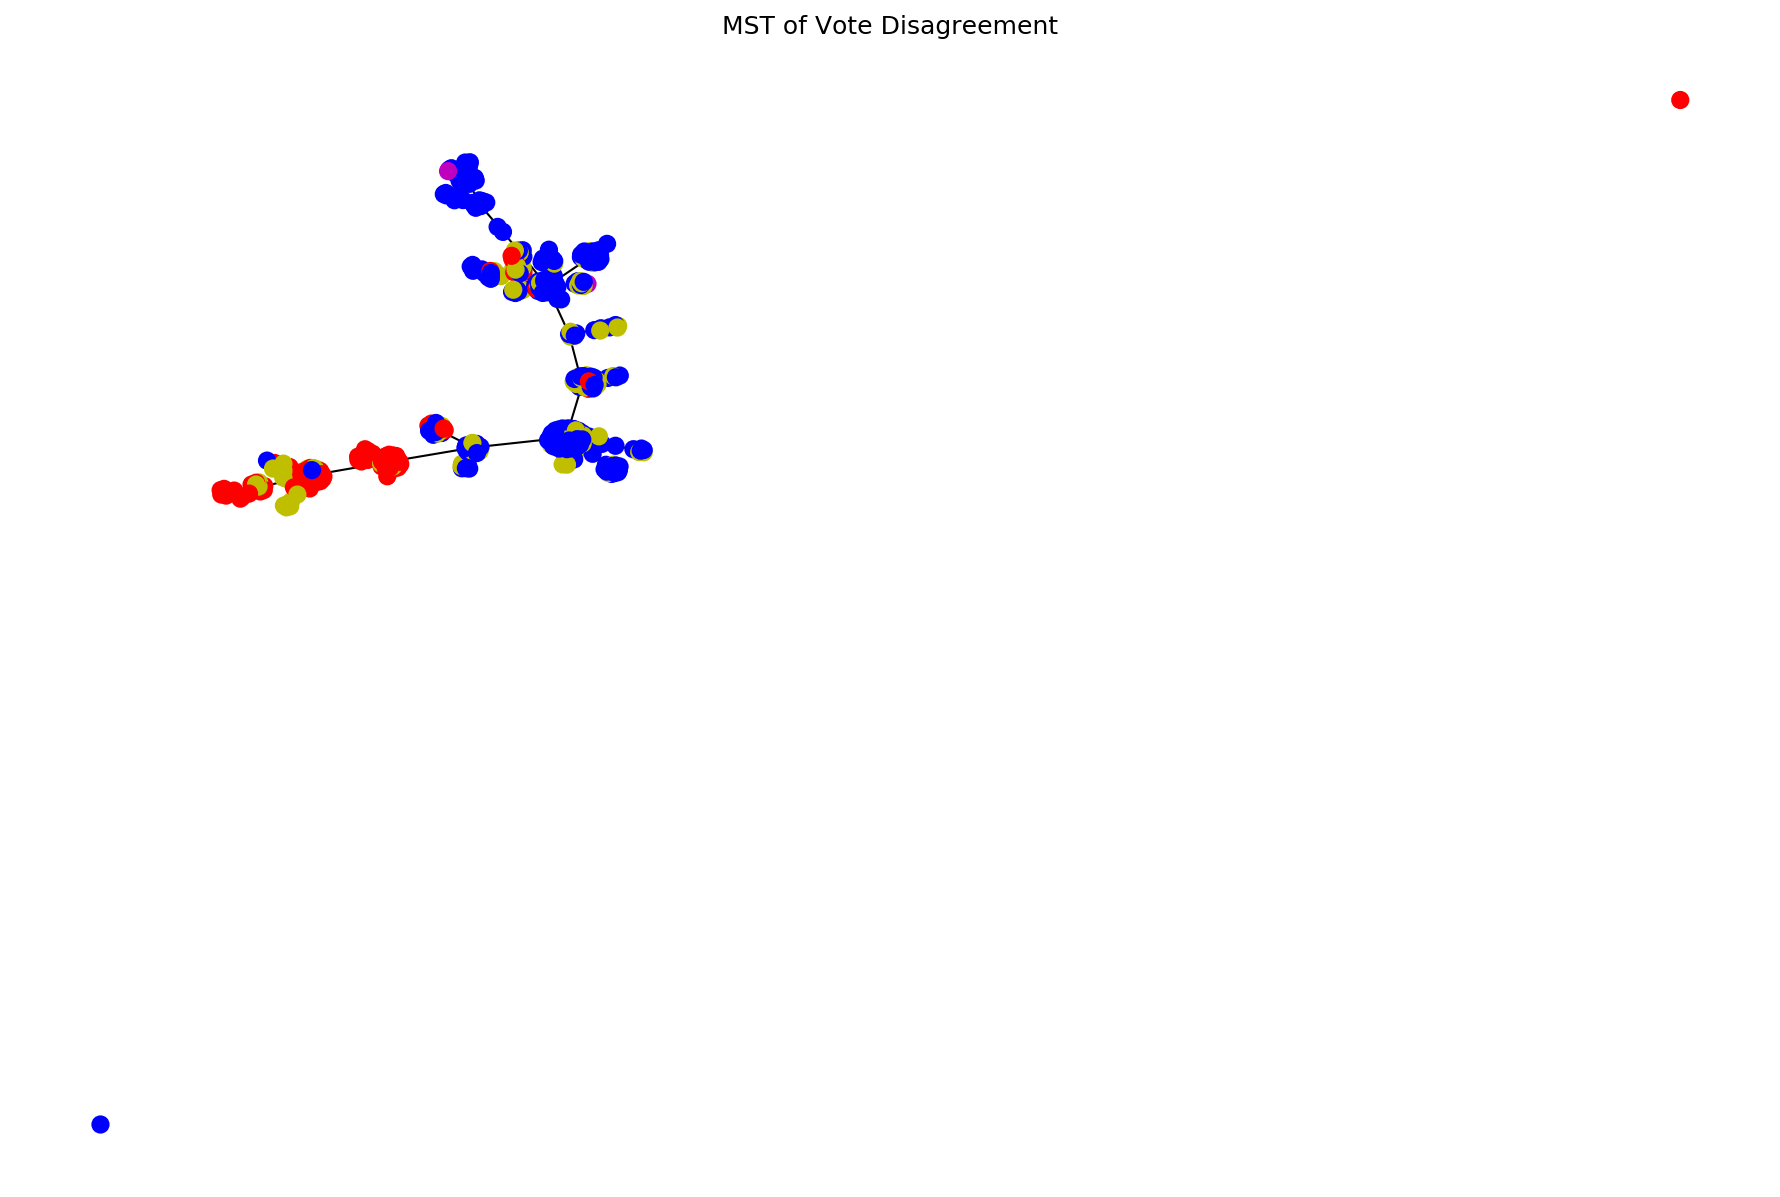

In [128]:
mst_votes(votes_net_jun,nomes_dep=False)

# Rede de votos de Julho

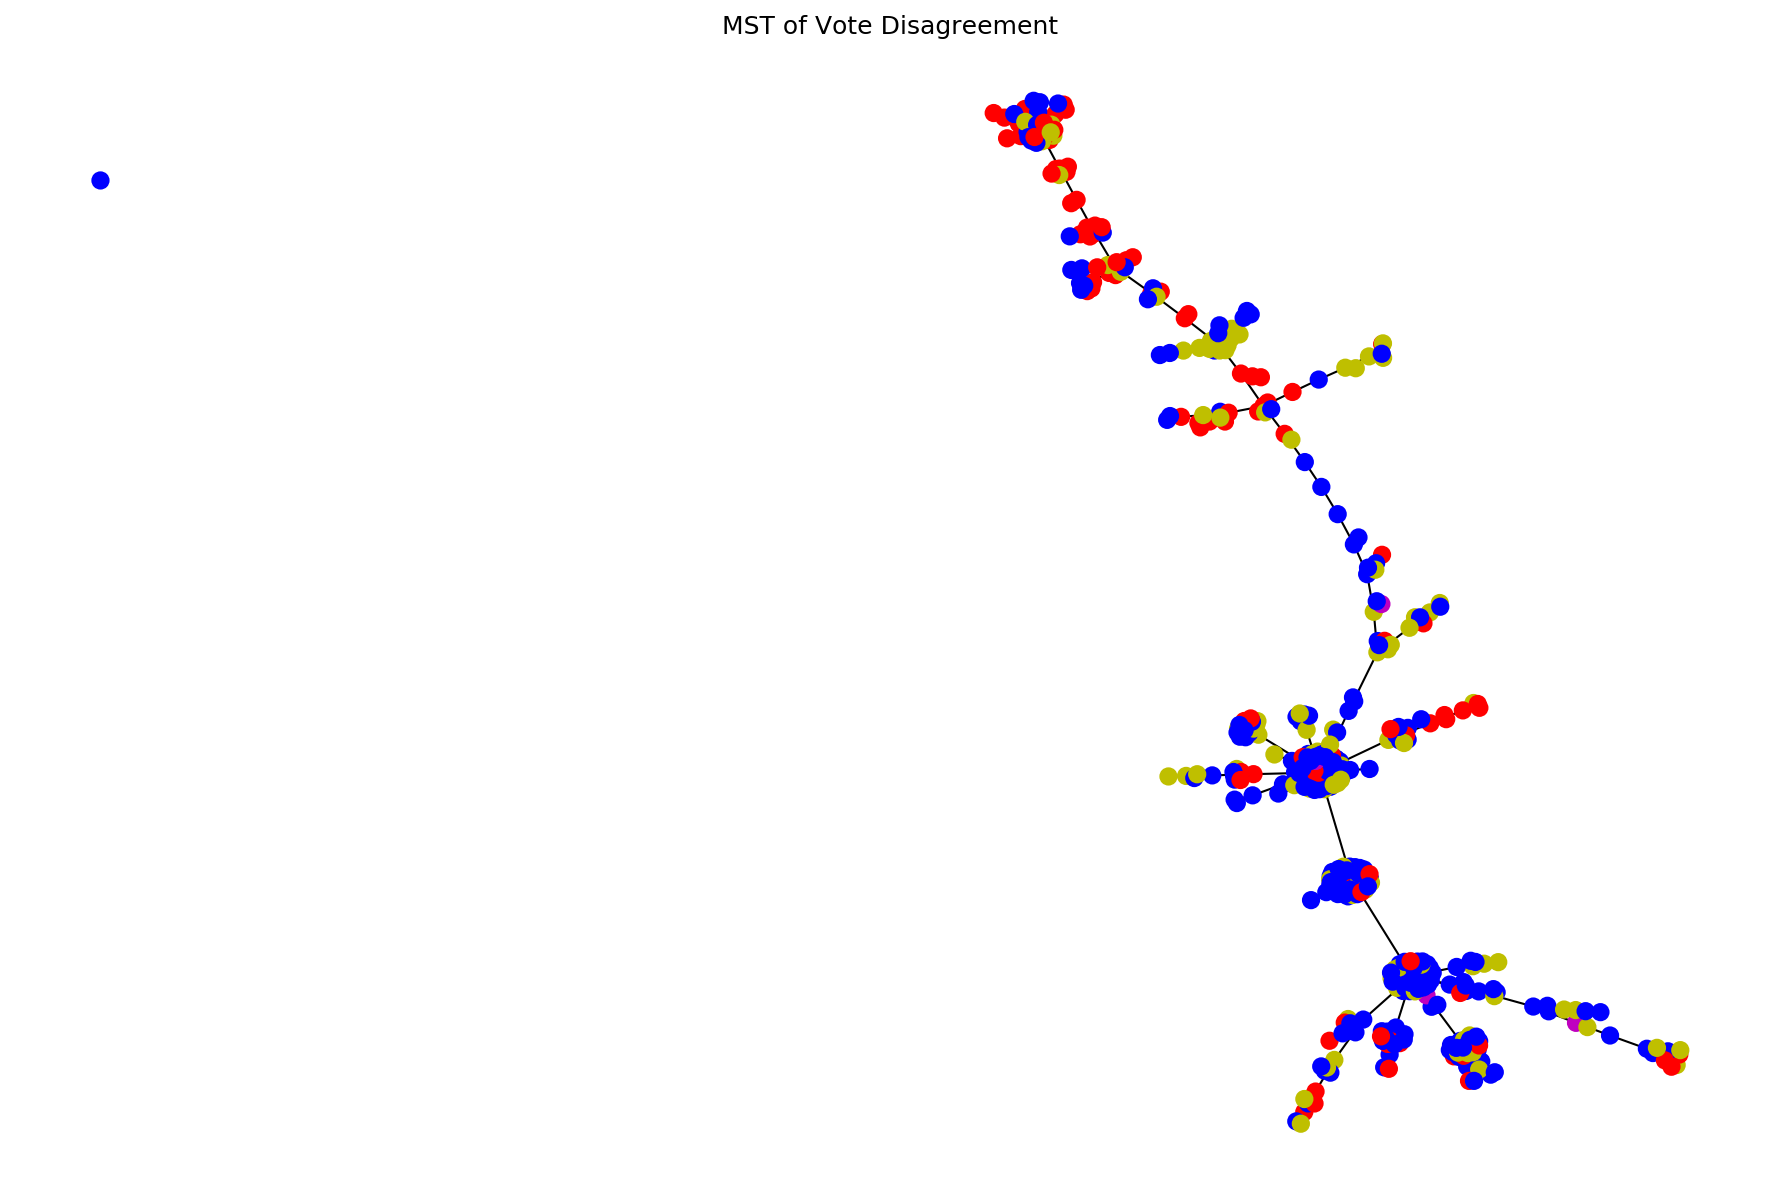

In [134]:
mst_votes(votes_net_jul,nomes_dep=False)

In [ ]:
np.random.seed(1)  

color = [votes_net.node[deputado]['color'] for deputado in votes_net.nodes()]

pos = nx.spring_layout(votes_net, iterations=400)
nx.draw_networkx_edges(votes_net, pos, alpha = .05)
nx.draw_networkx_nodes(votes_net, pos, node_color=color)
lbls = nx.draw_networkx_labels(votes_net, pos, alpha=5, font_size=5)

plt.xticks([])
plt.yticks([])
remove_border(left=False, bottom=False)